In [ ]:
%pip install selenium
%pip install beautifulsoup4
%pip install plotly
%pip install seaborn
%pip install scipy
%pip install nbformat

In [71]:
%pip freeze | findstr nbformat


nbformat==5.10.4
Note: you may need to restart the kernel to use updated packages.


Etap 1: Zbieranie danych

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

In [2]:
from selenium.webdriver.chrome.service import Service

download_service = Service()

driver = webdriver.Chrome(service=download_service)

driver.maximize_window()

The chromedriver version (131.0.6778.69) detected in PATH at I:\ChromeDriver\chromedriver.exe might not be compatible with the detected chrome version (132.0.6834.110); currently, chromedriver 132.0.6834.110 is recommended for chrome 132.*, so it is advised to delete the driver in PATH and retry


In [3]:
# Otwieranie strony Steam
url = "https://store.steampowered.com/category/science_fiction/"
driver.get(url)

# Czekanie na za≈Çadowanie tre≈õci
time.sleep(2)  # Dostosuj, je≈õli strona ≈Çaduje siƒô szybciej

In [5]:
# Znajd≈∫ i kliknij przycisk zamykajƒÖcy popup
popup_close_button = driver.find_element(By.ID, "rejectAllButton")
popup_close_button.click()

In [6]:
menu_button = driver.find_element(By.XPATH, "//div[text()='Typ']")
driver.execute_script("arguments[0].scrollIntoView(true);", menu_button)
menu_button.click()

# Znalezienie elementu rodzica (div) dla <a> z tekstem "Gry"
games_button = driver.find_element(By.XPATH, "//a[text()='Gry']")
# Klikniƒôcie elementu rodzica
driver.execute_script("arguments[0].click();", games_button)

In [7]:
import pandas as pd

def GetTitlesWithDetails():
    games_data = []
    game_containers = driver.find_elements(By.XPATH, "//div[contains(@class, 'v9uRg57bwOaPsvAnkXESO')]")

    for game in game_containers:
        try:
            # Pobranie tytu≈Çu gry
            title = game.find_element(By.XPATH, ".//div[contains(@class, '_3rrH9dPdtHVRMzAEw82AId')]//a//div").text.strip()

            # Pobranie tag√≥w
            tags_container = game.find_element(By.XPATH, ".//div[contains(@class, '_3wryhCRrTuMULeq_YjNk-s')]")
            tag_elements = tags_container.find_elements(By.XPATH, ".//div[contains(@class, '_2bkP-3b7dvr0a_qPdZEfHY')]//a")
            tags = ', '.join([tag.text.strip() for tag in tag_elements if tag.text.strip()])

            # Pobranie ceny gry
            try:
                price_container = game.find_element(By.XPATH, ".//div[contains(@class, 'kW6m4Sjqacp5hykrj5LEo')]//div[contains(@class, '_2s-O5T3qJJYR2AUq4b9jIN')]")
                price = price_container.find_element(By.XPATH, ".//div[contains(@class, '_3j4dI1yA7cRfCvK8h406OB')]").text.strip()
            except:
                price = "Free to Play"

            # Pobranie daty wydania
            try:
                release_date = game.find_element(By.XPATH, ".//div[contains(@class, '_3wryhCRrTuMULeq_YjNk-s')]//div[contains(@class, '_3a6HRK-P6LK0-pxRKXYgyP')]//div[contains(@class, '_1qvTFgmehUzbdYM9cw0eS7')]").text.strip()
            except:
                release_date = "Brak daty"

            # Pobranie nacechowania recenzji
            try:
                review_sentiment = game.find_element(By.XPATH, ".//div[contains(@class, '_3wryhCRrTuMULeq_YjNk-s')]//a[contains(@class, '_3qvppfM_u0yn2jrpoUo8RM')]//div[contains(@class, '_3ZWs0kB-1tuqQtie9KK-E7')]//div[contains(@class, '_2nuoOi5kC2aUI12z85PneA')]").text.strip()
            except:
                review_sentiment = "Brak informacji"

            # Pobranie liczby recenzji
            try:
                review_count = game.find_element(By.XPATH, ".//div[contains(@class, '_3wryhCRrTuMULeq_YjNk-s')]//a[contains(@class, '_3qvppfM_u0yn2jrpoUo8RM')]//div[contains(@class, '_3ZWs0kB-1tuqQtie9KK-E7')]//div[contains(@class, '_1wXL_MfRpdKQ3wZiNP5lrH')]").text.strip()
            except:
                review_count = "0"

            # Dodanie gry do listy
            games_data.append({
                "Tytu≈Ç": title,
                "Tagi": tags,
                "Cena": price,
                "Data wydania": release_date,
                "Nacechowanie recenzji": review_sentiment,
                "Liczba recenzji": review_count
            })

        except Exception as e:
            print(f"Problem z przetwarzaniem gry: {e}")

    # Konwersja do DataFrame
    df = pd.DataFrame(games_data)
    return df


In [8]:
# zecrolluj na d√≥≈Ç listy
driver.execute_script('window.scroll(0, document.body.scrollHeight-2000)')

# Powtarzanie procesu 10 razy
for i in range(40):
    load_more_button = driver.find_element(By.CLASS_NAME, '_2tkiJ4VfEdI9kq1agjZyNz.Focusable')
    load_more_button.click()
    driver.execute_script('window.scroll(0, document.body.scrollHeight-2000)')
    time.sleep(2)


data = GetTitlesWithDetails()

In [9]:
# Zamkniƒôcie drivera
driver.quit()

Etap 2: Czyszczenie danych

In [10]:
import pandas as pd
import numpy as np

def clean_data(df):
    # 1. Konwersja ceny
    def clean_price(price):
        try:
            if "Free to Play" in price:
                return 0.0
            return float(price.replace(' z≈Ç', '').replace(',', '.'))
        except:
            return np.nan

    df['Cena'] = df['Cena'].apply(clean_price)

    # 2. Konwersja liczby recenzji
    def clean_reviews(reviews):
        try:
            return int(reviews.replace('Recenzje u≈ºytkownik√≥w: ', '').replace(' ', ''))
        except:
            return np.nan

    df['Liczba recenzji'] = df['Liczba recenzji'].apply(clean_reviews)

    # 3. Konwersja daty wydania
    polish_months = {
        'STY': 'Jan', 'LUT': 'Feb', 'MAR': 'Mar', 'KWI': 'Apr', 'MAJ': 'May', 'CZE': 'Jun',
        'LIP': 'Jul', 'SIE': 'Aug', 'WRZ': 'Sep', 'PA≈π': 'Oct', 'LIS': 'Nov', 'GRU': 'Dec'
    }

    def clean_date(date):
        if pd.isna(date):
            return np.nan
        for pl, en in polish_months.items():
            date = date.replace(pl, en)
        try:
            return pd.to_datetime(date, format='%d %b %Y')
        except:
            return np.nan

    df['Data wydania'] = df['Data wydania'].apply(clean_date)

    # 4. Rozbicie tag√≥w na kolumny (one-hot encoding)
    def split_tags(tags):
        return tags.split(', ') if isinstance(tags, str) else []

    # Przygotowanie unikalnych tag√≥w
    all_tags = sorted(set(tag for tags in df['Tagi'].apply(split_tags) for tag in tags))
    
    # Tworzenie macierzy tag√≥w (one-hot encoding)
    tags_matrix = pd.DataFrame(
        {
            f'Tag_{tag}': df['Tagi'].apply(lambda tags: 1 if tag in split_tags(tags) else 0)
            for tag in all_tags
        }
    )
    
    # ≈ÅƒÖczenie oryginalnego DataFrame z macierzƒÖ tag√≥w
    df = pd.concat([df.reset_index(drop=True), tags_matrix.reset_index(drop=True)], axis=1)

    # Usuwanie potencjalnych brak√≥w danych (przyk≈Çad)
    df.dropna(subset=['Cena', 'Liczba recenzji', 'Data wydania'], inplace=True)

    return df


In [11]:
import pandas as pd

# Dane wej≈õciowe
df = pd.DataFrame(data)

# Przetwarzanie danych
df = clean_data(df)


In [53]:
display(df)

Tytu≈Ç  \
0                                Cyberpunk 2077   
1                             Space Engineers 2   
2                                 Marvel Rivals   
3    Dying Light 2 Stay Human: Reloaded Edition   
4                                      Among Us   
..                                          ...   
487                  Zanki Zero: Last Beginning   
488                Tom Clancy‚Äôs The Division¬Æ 2   
489                                      Chorus   
490                                Space Prison   
491                              Bears In Space   

                                                  Tagi    Cena Data wydania  \
0    Cyberpunk, Otwarty ≈õwiat, Nago≈õƒá, RPG, Jednoos...   89.55   2020-12-10   
1    Symulatory, Akcja, Strategiczne, Piaskownica, ...  138.99   2025-01-27   
2    Free to Play, Wieloosobowe, Strzelanka z bohat...    0.00   2024-12-06   
3    Otwarty ≈õwiat, Kooperacja, Zombie, Parkour, Wi...   65.99   2022-02-04   
4    Wieloosobowe, Sieciowa kooperacja, Dedukcyjne ...   10.79   2018-11-16   
..                                                 ...     ...          ...   
487  RPG, Dungeon crawler, Anime, Powie≈õƒá wizualna,...   21.49   2019-04-10   
488  Otwarty ≈õwiat, Strzelanka z ≈Çupami, Wieloosobo...  159.90   2023-01-12   
489  Akcja, Przygodowe, Niezale≈ºne, Kosmos, ≈ªe≈Ñska ...   21.12   2021-12-03   
490  Taktyczne turowe, Komiks, Strategiczne RPG, RP...   70.00   2024-07-18   
491  Jednoosobowe, Przygodowe, FPS, Platformowe 3D,...   41.40   2024-03-22   

      Nacechowanie recenzji  Liczba recenzji  Tag_2,5D  Tag_2D  Tag_3D  \
0          Bardzo pozytywne           717578         0       0       0   
1    W wiƒôkszo≈õci pozytywne              370         0       0       0   
2          Bardzo pozytywne           183495         0       0       0   
3    W wiƒôkszo≈õci pozytywne           137563         0       0       0   
4          Bardzo pozytywne           612177         0       0       0   
..                      ...              ...       ...     ...     ...   
487  W wiƒôkszo≈õci pozytywne              587         0       0       0   
488  W wiƒôkszo≈õci pozytywne            17357         0       0       0   
489        Bardzo pozytywne             3196         0       0       0   
490        Bardzo pozytywne              182         0       0       0   
491        Bardzo pozytywne              284         0       0       0   

     Tag_4X  ...  Tag_≈Åupy  Tag_≈öledztwo  Tag_≈öwietna ≈õcie≈ºka d≈∫wiƒôkowa  \
0         0  ...         0             0                              0   
1         0  ...         0             0                              0   
2         0  ...         0             0                              0   
3         0  ...         0             0                              0   
4         0  ...         0             0                              0   
..      ...  ...       ...           ...                            ...   
487       0  ...         0             0                              0   
488       0  ...         0             0                              0   
489       0  ...         0             0                              0   
490       0  ...         0             0                              0   
491       0  ...         0             0                              0   

     Tag_≈ªe≈Ñska postaƒá w roli g≈Ç√≥wnej  sentiment_score  Year  Cena_kategoria  \
0                                   0              3.0  2020          51-100   
1                                   0              NaN  2025         101-150   
2                                   0              3.0  2024             NaN   
3                                   0              NaN  2022          51-100   
4                                   0              3.0  2018            0-50   
..                                ...              ...   ...             ...   
487                                 0              NaN  2019            0-50   
488            

Etap 5: Dashboard

In [54]:
from collections import Counter
import pandas as pd
import plotly.express as px

def prepare_pie_chart_data(df, top_n=25):
    # Zliczanie wystƒÖpie≈Ñ tag√≥w
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_counts = Counter(tag for tag_list in tags for tag in tag_list)

    # Podzia≈Ç na najpopularniejsze tagi i kategoriƒô "Other"
    top_tags = tag_counts.most_common(top_n)
    other_count = sum(count for tag, count in tag_counts.items() if tag not in dict(top_tags))
    
    # Przygotowanie danych do DataFrame
    pie_data = pd.DataFrame(top_tags, columns=['Tag', 'Count'])
    if other_count > 0:
        other_row = pd.DataFrame([{'Tag': 'Other', 'Count': other_count}])
        pie_data = pd.concat([pie_data, other_row], ignore_index=True)
    
    return pie_data

# Przygotowanie danych do wykresu
pie_chart_data = prepare_pie_chart_data(df)

# Wizualizacja
fig = px.pie(pie_chart_data, names='Tag', values='Count',
             title='Liczba gier per tag (z kategoriƒÖ "Other")',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()


In [55]:
def prepare_pie_chart_reviews(df, top_n=20):
    # Zliczanie liczby recenzji na tag
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_reviews = Counter()

    for idx, tag_list in enumerate(tags):
        for tag in tag_list:
            tag_reviews[tag] += df.iloc[idx]['Liczba recenzji']

    # Podzia≈Ç na najpopularniejsze tagi i kategoriƒô "Other"
    top_tags = tag_reviews.most_common(top_n)
    other_count = sum(count for tag, count in tag_reviews.items() if tag not in dict(top_tags))
    
    # Przygotowanie danych do DataFrame
    pie_data = pd.DataFrame(top_tags, columns=['Tag', 'Review Count'])
    if other_count > 0:
        other_row = pd.DataFrame([{'Tag': 'Other', 'Review Count': other_count}])
        pie_data = pd.concat([pie_data, other_row], ignore_index=True)
    
    return pie_data

# Przygotowanie danych do wykresu
pie_chart_reviews_data = prepare_pie_chart_reviews(df)

# Wizualizacja
fig0 = px.pie(pie_chart_reviews_data, names='Tag', values='Review Count',
             title='Liczba opinii per tag (z kategoriƒÖ "Other")',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig0.show()


In [56]:
def prepare_avg_reviews_per_tag(df, top_n=20):
    # Zliczanie liczby recenzji na tag i liczby gier
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_reviews = Counter()
    tag_counts = Counter()

    for idx, tag_list in enumerate(tags):
        for tag in tag_list:
            tag_reviews[tag] += df.iloc[idx]['Liczba recenzji']
            tag_counts[tag] += 1

    # Obliczanie ≈õredniej liczby recenzji na tag
    avg_reviews = {tag: tag_reviews[tag] / tag_counts[tag] for tag in tag_reviews}

    # Przygotowanie danych: top N tag√≥w i kategoria "Other"
    sorted_avg_reviews = sorted(avg_reviews.items(), key=lambda x: x[1], reverse=True)
    top_tags = sorted_avg_reviews[:top_n]
    other_count = sum(tag_counts[tag] for tag, _ in sorted_avg_reviews[top_n:])

    # Przygotowanie DataFrame
    pie_data = pd.DataFrame(top_tags, columns=['Tag', 'Average Reviews'])
    if other_count > 0:
        other_row = pd.DataFrame([{'Tag': 'Other', 'Average Reviews': other_count}])
        pie_data = pd.concat([pie_data, other_row], ignore_index=True)
    
    return pie_data

# Przygotowanie danych do wykresu
avg_reviews_per_tag_data = prepare_avg_reviews_per_tag(df)

# Wizualizacja
fig = px.pie(avg_reviews_per_tag_data, names='Tag', values='Average Reviews',
             title='≈örednia liczba recenzji na tag (z kategoriƒÖ "Other")',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()


In [57]:
import plotly.express as px

fig1 = px.histogram(df, x='Cena', nbins=20, title='Rozk≈Çad cen gier')
fig1.update_layout(xaxis_title='Cena', yaxis_title='Liczba gier')
fig1.show()


In [58]:
from collections import Counter

# Zliczanie wystƒÖpie≈Ñ tag√≥w
tag_counts = Counter()
for tags in df['Tagi']:
    # Przekszta≈Çcenie stringa w listƒô tag√≥w, zak≈ÇadajƒÖc, ≈ºe sƒÖ oddzielone przecinkami
    tag_list = tags.split(', ')
    tag_counts.update(tag_list)

# Przekszta≈Çcenie wynik√≥w w DataFrame
tag_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values('Count', ascending=False)

# Wizualizacja
fig2 = px.bar(tag_df.head(20), x='Tag', y='Count', title='Najpopularniejsze tagi')
fig2.update_layout(yaxis_title='Liczba gier')
fig2.show()


In [ ]:
# 1. Zale≈ºno≈õƒá miƒôdzy cenƒÖ a liczbƒÖ recenzji

import plotly.express as px

# Ustalamy kolejno≈õƒá nacechowania recenzji od najbardziej pozytywnych do najmniej pozytywnych
category_order = ['Przyt≈ÇaczajƒÖco pozytywne', 'Bardzo pozytywne', 'W wiƒôkszo≈õci pozytywne', 'Pozytywne', 'Mieszane', 'W wiƒôkszo≈õci negatywne', 'Przyt≈ÇaczajƒÖco negatywne']

# Tworzymy wykres
fig3 = px.scatter(df, x='Cena', y='Liczba recenzji', color='Nacechowanie recenzji',
                 title='Cena vs. liczba recenzji', labels={'Cena': 'Cena (z≈Ç)', 'Liczba recenzji': 'Liczba recenzji'},
                 hover_data=['Tytu≈Ç'],
                 category_orders={'Nacechowanie recenzji': category_order},
                 color_continuous_scale='RdYlGn',  # Ustawienie palety kolor√≥w
                 color_discrete_map={'Przyt≈ÇaczajƒÖco pozytywne': 'green', 'Bardzo pozytywne': 'lightgreen', 
                                     'W wiƒôkszo≈õci pozytywne': 'yellow', 'Pozytywne': 'yellow', 
                                     'Mieszane': 'orange', 'W wiƒôkszo≈õci negatywne': 'red', 'Przyt≈ÇaczajƒÖco negatywne': 'darkred'})

# Wy≈õwietlamy wykres
fig3.show()



In [45]:
# 2. Zale≈ºno≈õƒá miƒôdzy cenƒÖ a nacechowaniem recenzji

# Mapowanie nacechowania na warto≈õci numeryczne
sentiment_map = {
    'Bardzo pozytywne': 3,
    'Pozytywne': 2,
    'Mieszane': 1,
    'Negatywne': 0
}
df['sentiment_score'] = df['Nacechowanie recenzji'].map(sentiment_map)

# Okre≈õlenie kolejno≈õci dla 'Nacechowanie recenzji'
category_order = ['Przyt≈ÇaczajƒÖco pozytywne', 'Bardzo pozytywne', 'W wiƒôkszo≈õci pozytywne', 'Pozytywne', 'Mieszane', 'W wiƒôkszo≈õci negatywne', 'Przyt≈ÇaczajƒÖco negatywne']

# Scatter plot
fig4 = px.box(df, x='Nacechowanie recenzji', y='Cena', title='Cena w zale≈ºno≈õci od nacechowania recenzji',
             labels={'Cena': 'Cena (z≈Ç)', 'Nacechowanie recenzji': 'Nacechowanie recenzji'},
             category_orders={'Nacechowanie recenzji': category_order})  # Dodajemy sortowanie

fig4.show()



In [47]:
# Upewnij siƒô, ≈ºe Data wydania jest w formacie datetime
df['Data wydania'] = pd.to_datetime(df['Data wydania'], errors='coerce')

# Wyodrƒôbnij rok i dodaj go do nowej kolumny
df['Rok wydania'] = df['Data wydania'].dt.year


In [59]:
# 3. Rozk≈Çad cen w zale≈ºno≈õci od daty wydania
import plotly.express as px
import pandas as pd

# Wykres liczby gier z podzia≈Çem na nacechowanie
# Grupowanie danych: liczba gier w zale≈ºno≈õci od nacechowania recenzji
count_data = df.groupby('Nacechowanie recenzji')['Tytu≈Ç'].count().reset_index()
count_data.rename(columns={'Tytu≈Ç': 'Liczba gier'}, inplace=True)

# Grupowanie danych: liczba gier w zale≈ºno≈õci od roku i nacechowania recenzji
grouped_data = df.groupby(['Rok wydania', 'Nacechowanie recenzji'])['Tytu≈Ç'].count().reset_index()
grouped_data.rename(columns={'Tytu≈Ç': 'Liczba gier'}, inplace=True)

# Wykres s≈Çupkowy z podzia≈Çem
fig5 = px.bar(grouped_data, x='Rok wydania', y='Liczba gier', color='Nacechowanie recenzji', barmode='stack',
             title='Liczba gier w zale≈ºno≈õci od roku wydania i nacechowania recenzji',
             labels={'Rok wydania': 'Rok wydania', 'Liczba gier': 'Liczba gier', 'Nacechowanie recenzji': 'Nacechowanie recenzji'},
             category_orders={'Nacechowanie recenzji': category_order})
fig5.show()

In [49]:
# Interaktywny Dashboard

import plotly.subplots as sp

# Histogram cen
fig1 = px.histogram(df, x='Cena', title='Rozk≈Çad cen gier', labels={'Cena': 'Cena (z≈Ç)'})

# Scatter plot cena vs liczba recenzji
fig2 = px.scatter(df, x='Cena', y='Liczba recenzji', color='Nacechowanie recenzji',
                  title='Cena vs. liczba recenzji', hover_data=['Tytu≈Ç'])

# Box plot cena vs nacechowanie recenzji
fig3 = px.box(df, x='Nacechowanie recenzji', y='Cena', title='Cena vs. nacechowanie recenzji')

# Scatter plot cena vs rok wydania
fig4 = px.scatter(df, x='Rok wydania', y='Cena', color='Nacechowanie recenzji',
                  title='Cena vs. rok wydania', hover_data=['Tytu≈Ç'])

# Kombinacja wykres√≥w w jednym dashboardzie
dashboard = sp.make_subplots(rows=2, cols=2, subplot_titles=('Rozk≈Çad cen', 'Cena vs. liczba recenzji',
                                                             'Cena vs. nacechowanie recenzji', 'Cena vs. rok wydania'))

dashboard.add_traces(fig1.data, rows=1, cols=1)
dashboard.add_traces(fig2.data, rows=1, cols=2)
dashboard.add_traces(fig3.data, rows=2, cols=1)
dashboard.add_traces(fig4.data, rows=2, cols=2)

dashboard.update_layout(height=800, width=1200, title_text='Dashboard analizy gier')
dashboard.show()


In [60]:
def tags_sentiment_analysis(df, top_n=10):
    sentiment_counts = {}
    for sentiment in df['Nacechowanie recenzji'].unique():
        if pd.isna(sentiment):
            continue
        tags = df[df['Nacechowanie recenzji'] == sentiment]['Tagi'].apply(lambda x: x.split(', '))
        tag_counter = Counter(tag for tag_list in tags for tag in tag_list)
        sentiment_counts[sentiment] = dict(tag_counter)

    # Konwersja na DataFrame i ograniczenie liczby tag√≥w
    sentiment_dfs = []
    for sentiment, counts in sentiment_counts.items():
        sentiment_df = pd.DataFrame(counts.items(), columns=['Tag', 'Count'])
        sentiment_df['Sentiment'] = sentiment
        sentiment_dfs.append(sentiment_df)

    combined_df = pd.concat(sentiment_dfs)
    top_tags = combined_df.groupby('Tag')['Count'].sum().nlargest(top_n).index
    return combined_df[combined_df['Tag'].isin(top_tags)]

# Analiza
tags_sentiment_df = tags_sentiment_analysis(df)

# Okre≈õlenie kolejno≈õci dla 'Sentiment'
category_order = ['Przyt≈ÇaczajƒÖco pozytywne', 'Bardzo pozytywne', 'W wiƒôkszo≈õci pozytywne', 'Pozytywne', 
                  'Mieszane', 'W wiƒôkszo≈õci negatywne', 'Przyt≈ÇaczajƒÖco negatywne']

# Wizualizacja
fig = px.bar(tags_sentiment_df, x='Tag', y='Count', color='Sentiment', barmode='group',
             title='PowiƒÖzanie najczƒô≈õciej wystƒôpujƒÖcych tag√≥w z nacechowaniem recenzji',
             labels={'Count': 'Liczba wystƒÖpie≈Ñ', 'Tag': 'Tag'},
             category_orders={'Sentiment': category_order})  # Dodajemy sortowanie dla sentimentu

fig.update_layout(xaxis_tickangle=45)
fig.show()

In [23]:
# Mapowanie tekstowego nacechowania recenzji na warto≈õci numeryczne
sentiment_map = {
    'Przyt≈ÇaczajƒÖco pozytywne': 4,
    'Bardzo pozytywne': 3,
    'W wiƒôkszo≈õci pozytywne': 2,
    'Mieszane': 1,
    'Negatywne': 0
}

df['sentiment_score'] = df['Nacechowanie recenzji'].map(sentiment_map).fillna(0)


In [62]:
# Obliczanie ≈õrednich ocen wa≈ºonych liczbƒÖ recenzji oraz ≈õrednich cen
def avg_sentiment_and_price_per_tag(df, top_n=20, min_games=3):
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_scores = Counter()
    tag_weights = Counter()
    tag_prices = Counter()
    tag_counts = Counter()

    for idx, tag_list in enumerate(tags):
        for tag in tag_list:
            sentiment_score = df.iloc[idx]['sentiment_score']
            review_count = df.iloc[idx]['Liczba recenzji']
            price = df.iloc[idx]['Cena']
            
            # Wa≈ºenie ocen liczbƒÖ recenzji
            tag_scores[tag] += sentiment_score * review_count
            tag_weights[tag] += review_count
            
            # Suma cen i liczba wystƒÖpie≈Ñ
            tag_prices[tag] += price
            tag_counts[tag] += 1

    # Obliczanie ≈õrednich ocen i cen (filtr minimalnej liczby gier)
    avg_data = {
        tag: {
            'Average Sentiment': tag_scores[tag] / tag_weights[tag],
            'Average Price': tag_prices[tag] / tag_counts[tag],
            'Game Count': tag_counts[tag]
        }
        for tag in tag_scores if tag_counts[tag] >= min_games
    }
    avg_df = pd.DataFrame.from_dict(avg_data, orient='index').reset_index()
    avg_df.rename(columns={'index': 'Tag'}, inplace=True)
    return avg_df.sort_values('Average Sentiment', ascending=False).head(top_n), \
           avg_df.sort_values('Average Sentiment', ascending=True).head(top_n)


In [63]:
import plotly.graph_objects as go

# Obliczanie wynik√≥w
top_positive_tags, top_negative_tags = avg_sentiment_and_price_per_tag(df, top_n=20, min_games=3)

def create_dual_axis_chart(df, title):
    fig = go.Figure()

    # S≈Çupki dla ≈õredniej oceny
    fig.add_trace(go.Bar(
        x=df['Tag'],
        y=df['Average Sentiment'],
        name='≈örednia ocena',
        marker_color='#90CAF9',  # ≈Åagodny pastelowy niebieski
        yaxis='y1'
    ))

    # Linie i punkty dla ≈õredniej ceny
    fig.add_trace(go.Scatter(
        x=df['Tag'],
        y=df['Average Price'],
        name='≈örednia cena',
        mode='lines+markers',
        marker=dict(color='red', size=10),
        line=dict(width=2, dash='dot'),
        yaxis='y2'
    ))

    # Konfiguracja osi Y
    fig.update_layout(
        title=title,
        xaxis=dict(title='Tagi', tickangle=45),
        yaxis=dict(
            title='≈örednia ocena',
            titlefont=dict(color='#90CAF9'),  # Dopasowany kolor tytu≈Çu osi
            tickfont=dict(color='#90CAF9'),
        ),
        yaxis2=dict(
            title='≈örednia cena (z≈Ç)',
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right'
        ),
        legend=dict(x=0.5, y=1.1, orientation='h')
    )

    return fig

# Przygotowanie wykres√≥w dla najlepszych i najgorszych tag√≥w
fig_positive = create_dual_axis_chart(top_positive_tags, 'Tagi z najlepszymi ocenami (wa≈ºone liczbƒÖ recenzji)')
fig_negative = create_dual_axis_chart(top_negative_tags, 'Tagi z najgorszymi ocenami (wa≈ºone liczbƒÖ recenzji)')

# Wy≈õwietlenie wykres√≥w
fig_positive.show()
fig_negative.show()


In [26]:
def avg_reviews_per_tag(df, top_n=20):
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_reviews = Counter()
    tag_counts = Counter()

    for idx, tag_list in enumerate(tags):
        for tag in tag_list:
            tag_reviews[tag] += df.iloc[idx]['Liczba recenzji']
            tag_counts[tag] += 1

    avg_reviews = {tag: tag_reviews[tag] / tag_counts[tag] for tag in tag_counts}
    avg_reviews_df = pd.DataFrame(list(avg_reviews.items()), columns=['Tag', 'Average Reviews'])
    return avg_reviews_df.nlargest(top_n, 'Average Reviews')

# Analiza
tag_avg_reviews_df = avg_reviews_per_tag(df)

# Wizualizacja
fig = px.bar(tag_avg_reviews_df, x='Tag', y='Average Reviews',
             title='≈örednia liczba recenzji na najpopularniejsze tagi',
             labels={'Average Reviews': '≈örednia liczba recenzji'})
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [27]:
def avg_price_per_tag(df, top_n=20):
    tags = df['Tagi'].apply(lambda x: x.split(', '))
    tag_prices = Counter()
    tag_counts = Counter()

    for idx, tag_list in enumerate(tags):
        for tag in tag_list:
            tag_prices[tag] += df.iloc[idx]['Cena']
            tag_counts[tag] += 1

    avg_prices = {tag: tag_prices[tag] / tag_counts[tag] for tag in tag_counts}
    avg_prices_df = pd.DataFrame(list(avg_prices.items()), columns=['Tag', 'Average Price'])
    return avg_prices_df.nlargest(top_n, 'Average Price')

# Analiza
tag_avg_price_df = avg_price_per_tag(df)

# Wizualizacja
fig = px.bar(tag_avg_price_df, x='Tag', y='Average Price',
             title='≈örednia cena dla najdro≈ºszych tag√≥w',
             labels={'Average Price': '≈örednia cena'})
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [ ]:
# tabela krzy≈ºowa potrzebna

In [39]:
# Tworzenie listy wszystkich unikalnych tag√≥w
all_tags = set(tag for tags in df['Tagi'].dropna() for tag in tags.split(', '))


In [ ]:
# Przeprowad≈∫ dok≈ÇadnƒÖ analizƒô, koncentrujƒÖc siƒô na odkrywaniu zale≈ºno≈õci, trend√≥w i wzorc√≥w. Metody analizy muszƒÖ byƒá dostosowane do typu danych.

# Przyk≈Çady:   - Dla szereg√≥w czasowych, mogƒÖ pasowaƒá takie metody jak ≈õrednie kroczƒÖce, metody dekompozycji, itd. - data wydania

#   - Dla danych kategorycznych, mo≈ºna u≈ºyƒá  jak tabele krzy≈ºowe, test chi-kwadrat,  itd. - nacechowanie recenzji

#   - Dla danych ciƒÖg≈Çych, mo≈ºemy u≈ºyƒá analizƒô korelacji, regresjƒô, itd. - cena, ew. liczba recenzji

Etap 4: Analiza danych

≈örednie kroczƒÖce szeregu czasowego

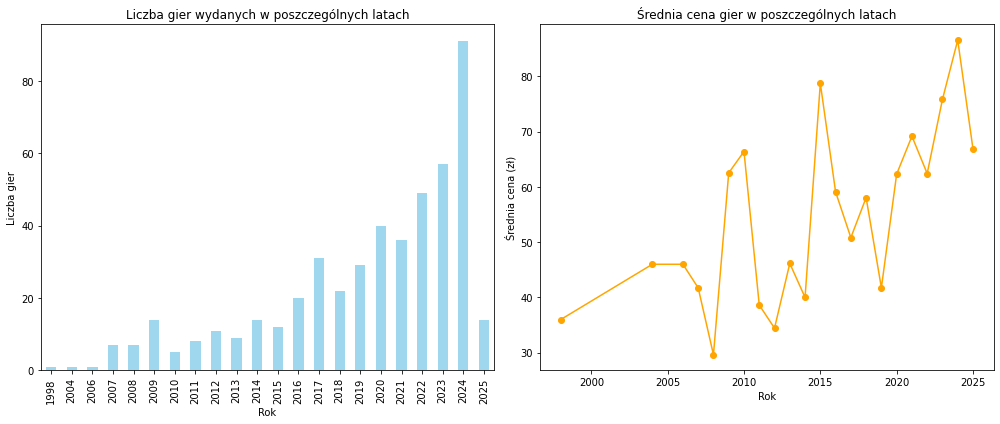

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Konwersja daty wydania na rok
df['Year'] = df['Data wydania'].dt.year

# Liczba gier wydanych w poszczeg√≥lnych latach
games_per_year = df.groupby('Year').size()

# ≈örednia cena gier w poszczeg√≥lnych latach
avg_price_per_year = df.groupby('Year')['Cena'].mean()

# Wizualizacja trend√≥w czasowych
plt.figure(figsize=(14, 6))

# Liczba gier na osi 1
plt.subplot(1, 2, 1)
games_per_year.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title("Liczba gier wydanych w poszczeg√≥lnych latach")
plt.xlabel("Rok")
plt.ylabel("Liczba gier")

# ≈örednia cena na osi 2
plt.subplot(1, 2, 2)
avg_price_per_year.plot(kind='line', marker='o', color='orange')
plt.title("≈örednia cena gier w poszczeg√≥lnych latach")
plt.xlabel("Rok")
plt.ylabel("≈örednia cena (z≈Ç)")

plt.tight_layout()
plt.show()


Dekompozycja szeregu czasowego

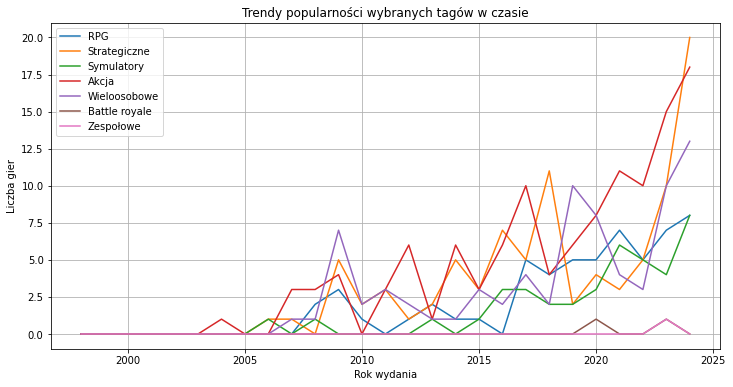

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Wykluczenie roku 2025
df_filtered = df[df['Rok wydania'] < 2025]

# Lista tag√≥w do analizy (np. najpopularniejsze)
tag_columns = [col for col in df_filtered.columns if col.startswith('Tag_')]

# Zliczanie wystƒÖpie≈Ñ ka≈ºdego tagu w danym roku
tag_trends = df_filtered.groupby('Rok wydania')[tag_columns].sum()

# Filtracja lat i uzupe≈Çnienie brak√≥w w danych dla lat, kt√≥re nie zawierajƒÖ ≈ºadnej gry
tag_trends = tag_trends.reindex(range(tag_trends.index.min(), tag_trends.index.max() + 1), fill_value=0)

# Wizualizacja trend√≥w dla wybranych tag√≥w
selected_tags = ['Tag_RPG', 'Tag_Strategiczne', 'Tag_Symulatory', 'Tag_Akcja', 'Tag_Wieloosobowe', 'Tag_Battle royale', 'Tag_Zespo≈Çowe']  # Przyk≈Çadowe tagi

plt.figure(figsize=(12, 6))
for tag in selected_tags:
    plt.plot(tag_trends.index, tag_trends[tag], label=tag.replace('Tag_', ''))

plt.title('Trendy popularno≈õci wybranych tag√≥w w czasie')
plt.xlabel('Rok wydania')
plt.ylabel('Liczba gier')
plt.legend()
plt.grid(True)
plt.show()


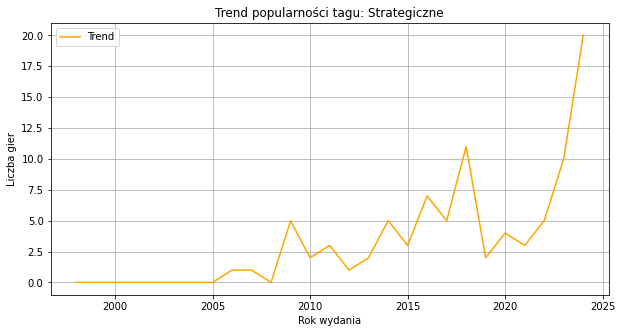

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Wyb√≥r jednego tagu do analizy trendu
tag_to_analyze = 'Tag_Strategiczne'
tag_data = tag_trends[tag_to_analyze]

# Dekompozycja szeregu czasowego (skupienie na trendzie)
decomposition = seasonal_decompose(tag_data, model='additive', period=1)

# Wizualizacja tylko trendu
plt.figure(figsize=(10, 5))
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title(f'Trend popularno≈õci tagu: {tag_to_analyze.replace("Tag_", "")}')
plt.xlabel('Rok wydania')
plt.ylabel('Liczba gier')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(cross_table):
    chi2, _, _, _ = chi2_contingency(cross_table)
    n = cross_table.sum().sum()
    phi2 = chi2 / n
    r, k = cross_table.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Eksplodowanie tag√≥w z resetowaniem indeksu
exploded_tags = df[['Nacechowanie recenzji', 'Tagi']].copy()
exploded_tags = exploded_tags.assign(Tag=exploded_tags['Tagi'].str.split(', ')).explode('Tag').reset_index(drop=True)

# Tabela krzy≈ºowa: Nacechowanie recenzji a tagi
cross_table = pd.crosstab(exploded_tags['Nacechowanie recenzji'], exploded_tags['Tag'])

# Obliczenie Cramer's V
cramers_v_value = cramers_v(cross_table)
print(f"Cramer's V: {cramers_v_value:.2f}")

Cramer's V: 0.37


Tagi - tabela korzy≈ºowa

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Zliczanie liczby wystƒÖpie≈Ñ ka≈ºdego tagu
tag_counts = df['Tagi'].str.split(', ').explode().value_counts()

# Wyb√≥r najpopularniejszych tag√≥w
top_tags = tag_counts.head(20).index

# Tworzenie macierzy wsp√≥≈Çwystƒôpowania tag√≥w
tag_matrix = pd.DataFrame(0, index=top_tags, columns=top_tags)

for tags in df['Tagi'].dropna().str.split(', '):
    for tag1 in tags:
        for tag2 in tags:
            if tag1 in top_tags and tag2 in top_tags:
                tag_matrix.loc[tag1, tag2] += 1

# Obliczenie korelacji miƒôdzy tagami
tag_corr = tag_matrix.corr()


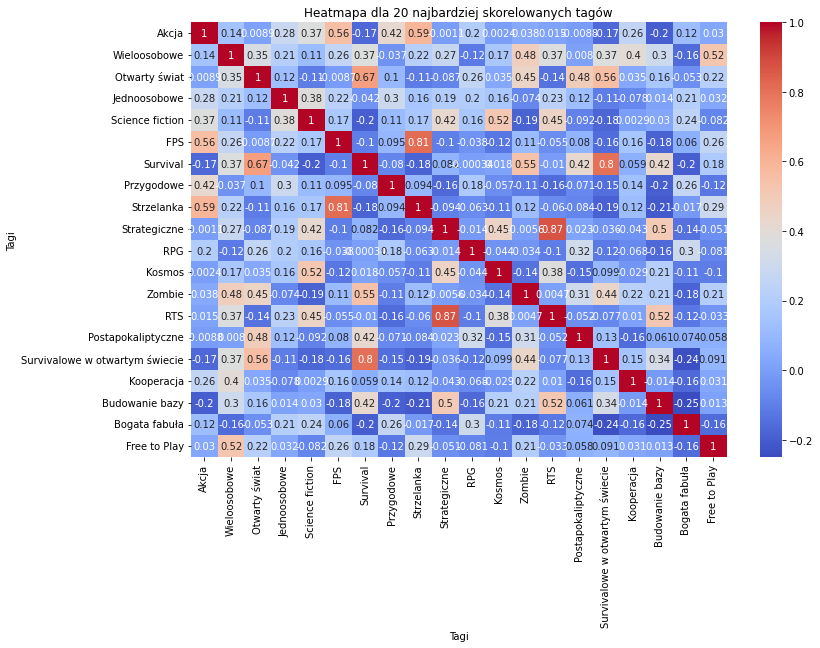

In [68]:
# Wybranie top 20 tag√≥w z najwy≈ºszƒÖ sumarycznƒÖ korelacjƒÖ
top_corr_tags = tag_corr.sum().sort_values(ascending=False).head(20).index
filtered_corr = tag_corr.loc[top_corr_tags, top_corr_tags]

# Heatmapa
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', xticklabels=top_corr_tags, yticklabels=top_corr_tags)
plt.title('Heatmapa dla 20 najbardziej skorelowanych tag√≥w')
plt.show()


In [89]:
cross_table.sum(axis=0).sort_values(ascending=False).head(10)


Tag
Akcja              125
Strategiczne        92
Science fiction     81
Wieloosobowe        78
Jednoosobowe        72
Przygodowe          69
Otwarty ≈õwiat       67
FPS                 65
Survival            62
RPG                 58
dtype: int64

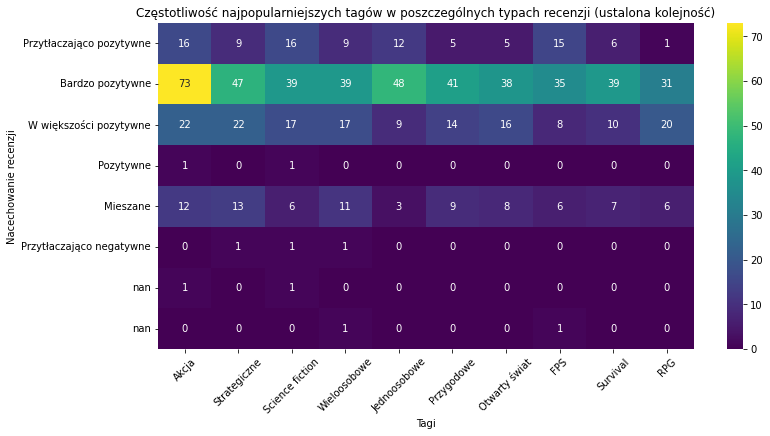

In [90]:
# Ustalona kolejno≈õƒá dla `Nacechowanie recenzji`
review_order = [
    'Przyt≈ÇaczajƒÖco pozytywne', 
    'Bardzo pozytywne', 
    'W wiƒôkszo≈õci pozytywne', 
    'Pozytywne', 
    'Mieszane', 
    'Bardzo negatywne', 
    'Przyt≈ÇaczajƒÖco negatywne'
]

# Wybieramy tylko 10 najpopularniejszych tag√≥w
top_tags = cross_table.sum(axis=0).sort_values(ascending=False).head(10).index
filtered_cross_table = cross_table[top_tags]

# Sortowanie `Nacechowanie recenzji` wed≈Çug liczby gier w ka≈ºdej kategorii
sorted_index = filtered_cross_table.sum(axis=1).sort_values(ascending=False).index
filtered_cross_table = filtered_cross_table.loc[sorted_index]

# Tworzenie kategorii z ustalonƒÖ kolejno≈õciƒÖ
cross_table.index = pd.Categorical(cross_table.index, categories=review_order, ordered=True)

# Sortowanie tabeli krzy≈ºowej wed≈Çug nowej kategorii
filtered_cross_table = cross_table[top_tags].sort_index()

# Tworzenie heatmapy
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_cross_table, cmap='viridis', annot=True, fmt='d', cbar=True)
plt.title('Czƒôstotliwo≈õƒá najpopularniejszych tag√≥w w poszczeg√≥lnych typach recenzji (ustalona kolejno≈õƒá)')
plt.xlabel('Tagi')
plt.ylabel('Nacechowanie recenzji')
plt.xticks(rotation=45)
plt.show()


In [39]:
%pip install statsmodels


  Using cached statsmodels-0.14.4-cp310-cp310-win_amd64.whl.metadata (9.5 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp310-cp310-win_amd64.whl (9.8 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
%pip install scikit-learn


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 11.1/11.1 MB 40.9 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Modelowanie: Zdecyduj, czy problem to klasyfikacja, czy regresja. Wykorzystaj odpowiednie modele uczenia maszynowego (np. drzewa decyzyjne, regresjƒô logistycznƒÖ dla klasyfikacji; regresjƒô liniowƒÖ, lasy losowe dla regresji) z biblioteki `scikit-learn` i oce≈Ñ ich wyniki przy u≈ºyciu takich miar jak dok≈Çadno≈õƒá (accuracy), F1 score lub R-kwadrat (R¬≤), w zale≈ºno≈õci od typu danych i analizy.

# 1. na podstawie tag√≥w, ceny i roku wydania oce≈Ñ, jakie opinie ma gra - klasyfikacja
# 2. na podstawie tag√≥w, opinii, liczby opinii, roku wydania zgadnij, jakƒÖ cenƒô ma gra - regresja

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Kodowanie nacechowania recenzji na warto≈õci numeryczne
label_encoder = LabelEncoder()
df['Nacechowanie recenzji_encoded'] = label_encoder.fit_transform(df['Nacechowanie recenzji'])

# Przygotowanie cech (X) i etykiet (y)
X = df[['Cena', 'Year'] + [col for col in df.columns if col.startswith('Tag_')]]  # Cena, rok wydania i tagi
y = df['Nacechowanie recenzji_encoded']

# Podzia≈Ç danych na zbi√≥r treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Klasyfikator: Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = clf.predict(X_test)

# Ocena modelu
print("Dok≈Çadno≈õƒá (Accuracy):", accuracy_score(y_test, y_pred))
print("\nRaport klasyfikacji:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Dok≈Çadno≈õƒá (Accuracy): 0.5729166666666666


ValueError: Number of classes, 5, does not match size of target_names, 8. Try specifying the labels parameter

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Przygotowanie cech (X) i zmiennej celu (y)
X = df[['Liczba recenzji', 'Year'] + [col for col in df.columns if col.startswith('Tag_')]]
X['Nacechowanie recenzji_encoded'] = df['Nacechowanie recenzji_encoded']
y = df['Cena']

# Podzia≈Ç danych na zbi√≥r treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regressor: Random Forest
reg = RandomForestRegressor(n_estimators=100, random_state=42)
# Standaryzacja cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trening modelu regresji na danych standaryzowanych
reg.fit(X_scaled, y)
y_pred = reg.predict(scaler.transform(X_test))

# Obliczenie metryk
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-kwadrat (R¬≤):", r2_score(y_test, y_pred))

C:\Users\awodz\AppData\Local\Temp\ipykernel_25056\3820707793.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



NameError: name 'StandardScaler' is not defined

In [23]:
%pip install sklearn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  √ó Getting requirements to build wheel did not run successfully.
  ‚îÇ exit code: 1
  ‚ï∞‚îÄ> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/s

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Przygotowanie danych
tag_matrix = pd.DataFrame(0, index=df.index, columns=all_tags)
for i, tags in enumerate(df['tags']):
    tag_matrix.loc[i, tags] = 1

scaler = StandardScaler()
X = scaler.fit_transform(tag_matrix)

# Klasteryzacja
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Wizualizacja klastr√≥w (kolor + centroidy)
fig = px.scatter(df, x='price', y='tag_count', color='cluster', title='Klasteryzacja gier (cena vs liczba tag√≥w)', labels={'price': 'Cena (z≈Ç)', 'tag_count': 'Liczba tag√≥w'}, hover_data=['title'])
fig.show()


ModuleNotFoundError: No module named 'sklearn'